# Multi-Class Image Classification Model for Land Use and Land Cover with Sentinel-2 Using TensorFlow Take 4
### David Lowe
### April 16, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Land Use and Land Cover with Sentinel-2 dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: This dataset is part of a research study that addresses the challenge of land use and land cover classification using Sentinel-2 satellite images. The research project presented a novel dataset based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes within a total of 27,000 labeled and geo-referenced images. The study project also provided benchmarks for this novel dataset with its spectral bands using deep Convolutional Neural Network (CNNs).

In iteration Take1, we constructed a CNN model using a simple three-block VGG architecture and tested the model's performance using a validation dataset (20%) set aside from the training images.

In iteration Take2, we constructed a CNN model using the DenseNet121 architecture and tested the model's performance using a validation dataset (20%) set aside from the training images.

In iteration Take3, we constructed a CNN model using the EfficientNetB0 architecture and tested the model's performance using a validation dataset (20%) set aside from the training images.

In this Take4 iteration, we will construct a CNN model using the ResNet101 architecture and test the model's performance using a validation dataset (20%) set aside from the training images.

ANALYSIS: From iteration Take1, the baseline model's performance achieved an accuracy score of 98.83% on the training dataset after 20 epochs. Furthermore, the final model achieved an accuracy score of 86.06% on the validation dataset.

From iteration Take2, the DenseNet121 model's performance achieved an accuracy score of 99.10% on the training dataset after 20 epochs. Furthermore, the final model achieved an accuracy score of 85.37% on the validation dataset.

From iteration Take3, the EfficientNetB0 model's performance achieved an accuracy score of 96.04% on the training dataset after 20 epochs. Furthermore, the final model achieved an accuracy score of 85.54% on the validation dataset.

In this Take4 iteration, the ResNet101 model's performance achieved an accuracy score of 93.47% on the training dataset after 20 epochs. Furthermore, the final model achieved an accuracy score of 85.30% on the validation dataset.

CONCLUSION: In this iteration, the ResNet101 CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with more CNN architectures for further modeling.

Dataset Used: Land Use and Land Cover with Sentinel-2

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: https://github.com/phelber/eurosat

A potential source of performance benchmarks: https://github.com/phelber/eurosat

A deep-learning image classification project generally can be broken down into five major tasks:

1. Prepare Environment
2. Load and Prepare Images
3. Define and Train Models
4. Evaluate and Optimize Models
5. Finalize Model and Make Predictions

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Apr  5 19:44:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    37W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 8

In [6]:
# Load libraries and packages
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import zipfile
from datetime import datetime
import h5py
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
TEST_SET_SIZE = 0.2
VAL_SET_SIZE = 0.25

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCH = 20
BATCH_SIZE = 64
RAW_IMAGE_SIZE = (64, 64)
TARGET_IMAGE_SIZE = (64, 64)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

NUM_CLASSES = 10
CLASS_LABELS = ['AnnualCrop',
                'Forest',
                'HerbaceousVegetation',
                'Highway',
                'Industrial',
                'Pasture',
                'PermanentCrop',
                'Residential',
                'River',
                'SeaLake']
# CLASS_NAMESS = []

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Define the directory locations and file names
TRAIN_DIR = 'staging/2750/'
# VALID_DIR = 'staging/'
# TEST_DIR = ''
# TRAIN_DATASET = ''
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.4.1


In [8]:
# Set up the parent directory location for loading the dotenv files
# Mount Google Drive locally for storing files
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# env_path = "/Users/david/PycharmProjects/"
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [11]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [12]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm EuroSAT.zip

In [15]:
STAGING_DIR = 'staging/'
!mkdir staging/

In [16]:
!wget https://dainesanalytics.com/datasets/tensorflow-land-use-cover-sentinel2/EuroSAT.zip

--2021-04-05 19:44:14--  https://dainesanalytics.com/datasets/tensorflow-land-use-cover-sentinel2/EuroSAT.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.224.8.47, 13.224.8.76, 13.224.8.32, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.224.8.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  31.2MB/s    in 2.9s    

2021-04-05 19:44:17 (31.2 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



In [17]:
# Unzip and put the files into the staging folder
local_zip = 'EuroSAT.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [18]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:10])

Number of training images for AnnualCrop : 3000
Training samples for AnnualCrop : ['AnnualCrop_1413.jpg', 'AnnualCrop_2978.jpg', 'AnnualCrop_2341.jpg', 'AnnualCrop_2892.jpg', 'AnnualCrop_1581.jpg', 'AnnualCrop_1399.jpg', 'AnnualCrop_2407.jpg', 'AnnualCrop_23.jpg', 'AnnualCrop_378.jpg', 'AnnualCrop_2321.jpg']
Number of training images for Forest : 3000
Training samples for Forest : ['Forest_2591.jpg', 'Forest_2524.jpg', 'Forest_1932.jpg', 'Forest_2276.jpg', 'Forest_1064.jpg', 'Forest_2691.jpg', 'Forest_1883.jpg', 'Forest_1378.jpg', 'Forest_113.jpg', 'Forest_2022.jpg']
Number of training images for HerbaceousVegetation : 3000
Training samples for HerbaceousVegetation : ['HerbaceousVegetation_2158.jpg', 'HerbaceousVegetation_1309.jpg', 'HerbaceousVegetation_2752.jpg', 'HerbaceousVegetation_1562.jpg', 'HerbaceousVegetation_313.jpg', 'HerbaceousVegetation_1851.jpg', 'HerbaceousVegetation_2533.jpg', 'HerbaceousVegetation_1847.jpg', 'HerbaceousVegetation_2549.jpg', 'HerbaceousVegetation_1792.

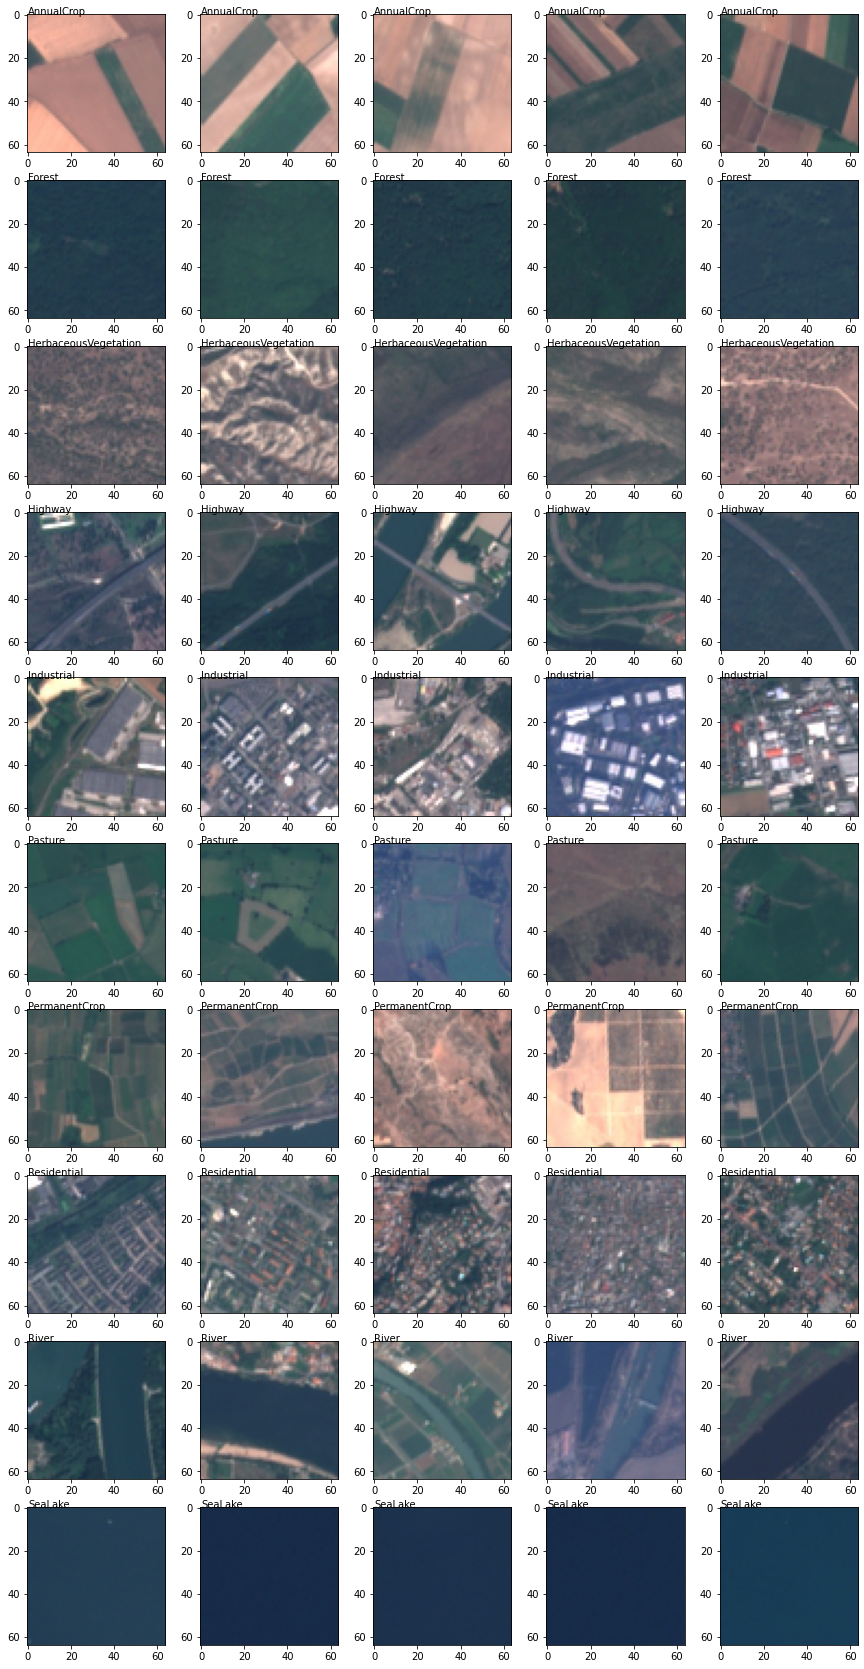

In [19]:
# Plot some training images from the dataset
nrows = 10
ncols = 5
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 3, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(c_label+'/'+training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(TRAIN_DIR + img_path)
    plt.imshow(img)
plt.show()

In [20]:
datagen_kwargs = dict(rescale=1./255, validation_split=TEST_SET_SIZE)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = False
if do_data_augmentation:
    training_datagen = ImageDataGenerator(fill_mode="constant",
                                          shear_range=0.2,
                                          zoom_range=(0.5, 1),
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          rotation_range=360,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          brightness_range=(0.75, 1.25),
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          subset='training',
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              subset='validation',
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 21600 images belonging to 10 classes.
Number of image batches per epoch of modeling: 675
Loading and pre-processing the validation images...
Found 5400 images belonging to 10 classes.
Number of image batches per epoch of modeling: 169


In [21]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [22]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [23]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
#         if metric == train_loss:
#             plt.ylim([0, plt.ylim()[1]])
#         else:
#             plt.ylim([0.5, 1.1])
        plt.legend()

In [24]:
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    nn_model = keras.applications.ResNet101(include_top=True, weights=None, input_shape=input_param, classes=output_param)
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [25]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.000001)
reset_random(RNG_SEED)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=MAX_EPOCH,
    callbacks=[learning_rate_reduction],
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/20
675/675 [==============================] - 72s 91ms/step - loss: 2.0272 - accuracy: 0.3981 - val_loss: 1.6318 - val_accuracy: 0.3928
Epoch 2/20
675/675 [==============================] - 60s 88ms/step - loss: 1.2241 - accuracy: 0.5795 - val_loss: 2.0760 - val_accuracy: 0.4352
Epoch 3/20
675/675 [==============================] - 60s 88ms/step - loss: 1.0153 - accuracy: 0.6577 - val_loss: 3.3381 - val_accuracy: 0.2667
Epoch 4/20
675/675 [==============================] - 60s 88ms/step - loss: 1.1392 - accuracy: 0.6155 - val_loss: 1.4872 - val_accuracy: 0.4728
Epoch 5/20
675/675 [==============================] - 60s 88ms/step - loss: 0.8710 - accuracy: 0.7047 - val_loss: 2.4742 - val_accuracy: 0.3380
Epoch 6/20
675/675 [==============================] - 59s 88ms/step - loss: 0.9449 - accuracy: 0.6983 - val_loss: 1.7209 - val_accuracy: 0.4176

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/20
675/675 [==============================] - 6

In [26]:
baseline_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

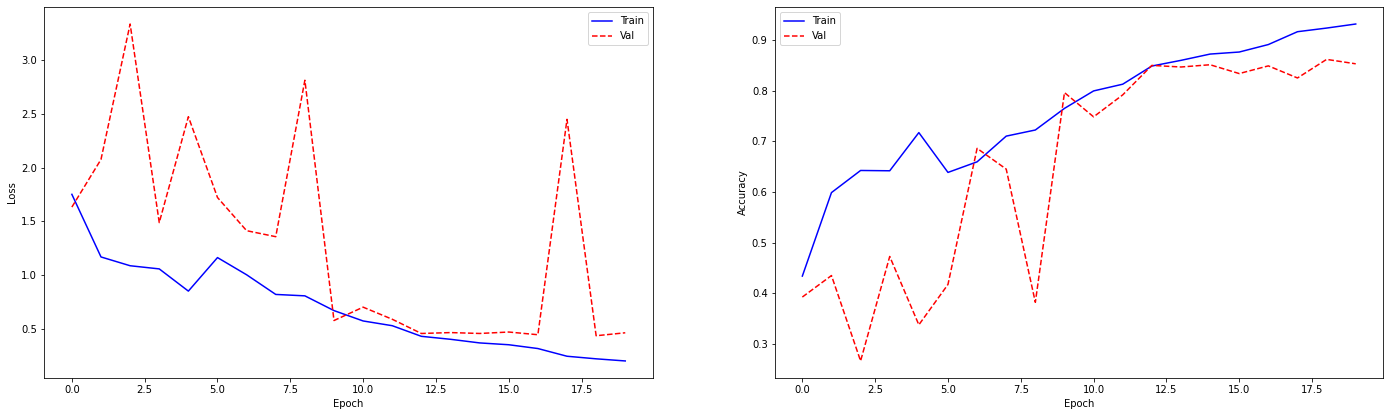

In [27]:
plot_metrics(baseline_model_history)

In [28]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Evaluate and Optimize Models

In [29]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [30]:
# Not applicable for this iteration of modeling

In [31]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 4 - Evaluate and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [32]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [33]:
# Not applicable for this iteration of modeling

In [34]:
if notifyStatus: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [35]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:20:20.887470
